# Fill rates of LOB 

In [20]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import seaborn as sns
import matplotlib.gridspec as gridspec
import math


from BSE import market_session

import matplotlib.pyplot as plt

# Set global font sizes
plt.rcParams['font.size'] = 18  # Default font size for all text
plt.rcParams['axes.titlesize'] = 18  # Font size for plot titles
plt.rcParams['axes.labelsize'] = 18  # Font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 18  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 18  # Font size for y tick labels
plt.rcParams['legend.fontsize'] = 18  # Font size for legend
plt.rcParams['figure.titlesize'] = 18  # Font size for figure titles


In [21]:
# Setting file path locations 
id = 'new_trader_chart_0_'
#id = 'heston_model_session_0_'
file_path = id + 'LOB_frames.csv'
prices = id + "tape.csv"
volumes = id + 'blotters.csv'
balances = id + 'avg_balance.csv'

In [22]:
tape_df = pd.read_csv(prices, header=None, names=['Type', 'Time', 'Price'])
tape_df.head(5)

,Type,Time,Price
0,Trd,0.400,141
1,Trd,0.458,179
2,Trd,0.683,230
3,Trd,0.700,231
4,Trd,0.767,222


In [23]:
# Initialize lists
time_list, bid_total_quantity, bid_prices, bid_quantities = [], [], [], []
ask_total_quantity, ask_prices, ask_quantities = [], [], []

# Read the file and parse the data
with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        
        # Split the line using "Bid:" and "Ask:" as delimiters
        parts = re.split(r'(Bid:|Ask:)', line)
        time_stamp = float(parts[0].strip().rstrip(','))
        
        # Parse bid and ask data
        bid_data, ask_data = [], []
        for i in range(1, len(parts) - 1, 2):
            values = [int(val) for val in parts[i + 1].strip().split(',') if val.strip().isdigit()]
            if parts[i] == 'Bid:':
                bid_data = values
            elif parts[i] == 'Ask:':
                ask_data = values
        
        # Extract and assign bid data
        if bid_data:
            bid_total_quantity.append(bid_data[0])
            bid_prices.append(bid_data[1::2])  # Take prices at odd indices
            bid_quantities.append(bid_data[2::2])  # Take quantities at even indices
        else:
            bid_total_quantity.append(None)
            bid_prices.append([])
            bid_quantities.append([])
        
        # Extract and assign ask data
        if ask_data:
            ask_total_quantity.append(ask_data[0])
            ask_prices.append(ask_data[1::2])  # Take prices at odd indices
            ask_quantities.append(ask_data[2::2])  # Take quantities at even indices
        else:
            ask_total_quantity.append(None)
            ask_prices.append([])
            ask_quantities.append([])

        # Store the timestamp
        time_list.append(time_stamp)

# Create the expanded DataFrame
expanded_df = pd.DataFrame({
    'Time': time_list,
    'Bid Total Quantity': bid_total_quantity,
    'Bid Prices': [', '.join(map(str, prices)) for prices in bid_prices],
    'Bid Quantities': [', '.join(map(str, quantities)) for quantities in bid_quantities],
    'Ask Total Quantity': ask_total_quantity,
    'Ask Prices': [', '.join(map(str, prices)) for prices in ask_prices],
    'Ask Quantities': [', '.join(map(str, quantities)) for quantities in ask_quantities]
})

# Display the expanded DataFrame
expanded_df.head(5)


,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities
0,0.000,0,,,0,,
1,0.067,0,,,1,260,1
2,0.133,0,,,2,"260, 447","1, 1"
3,0.142,1,139,1,2,"260, 447","1, 1"
4,0.167,1,139,1,3,"260, 291, 447","1, 1, 1"


In [24]:
def parse_price_string(price_str):
    """
    Given a string like '3,4,5,6', parse and return [3, 4, 5, 6] as integers.
    If the cell is empty or None, return an empty list.
    """
    if not price_str:  # handles None or empty
        return []
    # Split on commas and convert each piece to int
    return [int(p) for p in price_str.split(',') if p.strip().isdigit()]

# Parse the Bid Prices and Ask Prices columns into lists of integers
expanded_df['ParsedBidPrices'] = expanded_df['Bid Prices'].apply(parse_price_string)
expanded_df['ParsedAskPrices'] = expanded_df['Ask Prices'].apply(parse_price_string)

# Compute the highest bid and lowest ask at each timestamp
expanded_df['HighestBid'] = expanded_df['ParsedBidPrices'].apply(lambda prices: max(prices) if prices else None)
expanded_df['LowestAsk'] = expanded_df['ParsedAskPrices'].apply(lambda prices: min(prices) if prices else None)

# Display the resulting DataFrame with the new columns
expanded_df[['Time', 'HighestBid', 'LowestAsk']].head(5)

,Time,HighestBid,LowestAsk
0,0.000,NaN,NaN
1,0.067,NaN,260.0
2,0.133,NaN,260.0
3,0.142,139.0,260.0
4,0.167,139.0,260.0


In [25]:
expanded_df['MidPrice'] = 0.5 * (expanded_df['HighestBid'] + expanded_df['LowestAsk'])

In [26]:
# Initialize an empty list to store each trade as a dictionary
trades = []

# Variable to keep track of the current trader ID
current_trader = None

# Open and read the CSV file line by line
with open(volumes, 'r') as file:
    for line in file:
        parts = line.strip().split(', ')
        
        # Check if line indicates a new trader's trade count (e.g., "B00, 8")
        if len(parts) == 2 and parts[1].isdigit():
            current_trader = parts[0]  # Set the trader ID (e.g., "B00")
        
        # Check if line has enough parts to be a trade entry
        elif len(parts) >= 7:
            # Create a dictionary for each trade entry
            trade = {
                'TraderID': current_trader,
                'Type': parts[1],
                'Timestamp': float(parts[2]),
                'Price': int(parts[3]),
                'Seller': parts[4],
                'Buyer': parts[5],
                'Quantity': int(parts[6])
            }
            trades.append(trade)
        else:
            print(f"Skipping line due to unexpected format: {line}")

# Convert the list of trades to a DataFrame
blotters = pd.DataFrame(trades)

# Display the resulting DataFrame
blotters.head(5)

,TraderID,Type,Timestamp,Price,Seller,Buyer,Quantity
0,B00,Trade,3.825,162,S34,B00,1
1,B00,Trade,6.117,235,S41,B00,1
2,B00,Trade,7.067,229,S54,B00,1
3,B00,Trade,8.367,240,S50,B00,1
4,B00,Trade,14.683,225,S26,B00,1


In [27]:
# Sort the blotters DataFrame by the Timestamp column in ascending order
blotters_sorted = blotters.sort_values(by='Timestamp').reset_index(drop=True)

In [28]:
expanded_df['MidPrice'] = 0.5 * (expanded_df['HighestBid'] + expanded_df['LowestAsk'])
expanded_df['BuyDepth'] = blotters['Price'] - expanded_df['HighestBid']  
expanded_df['SellDepth'] = expanded_df['LowestAsk'] - blotters['Price']

expanded_df.head(5)

,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities,ParsedBidPrices,ParsedAskPrices,HighestBid,LowestAsk,MidPrice,BuyDepth,SellDepth
0,0.000,0,,,0,,,[],[],NaN,NaN,NaN,NaN,NaN
1,0.067,0,,,1,260,1,[],[260],NaN,260.0,NaN,NaN,25.0
2,0.133,0,,,2,"260, 447","1, 1",[],"[260, 447]",NaN,260.0,NaN,NaN,31.0
3,0.142,1,139,1,2,"260, 447","1, 1",[139],"[260, 447]",139.0,260.0,199.5,101.0,20.0
4,0.167,1,139,1,3,"260, 291, 447","1, 1, 1",[139],"[260, 291, 447]",139.0,260.0,199.5,86.0,35.0


In [29]:
# Merge trades with order book data using Timestamp
merged_df = expanded_df.merge(blotters_sorted, left_on='Time', right_on='Timestamp', how='left')

# Fill NaN values (if no trade occurred at a specific order book update, assume 0 market orders)
merged_df['Quantity'] = merged_df['Quantity'].fillna(0)

merged_df.head(5)


,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities,ParsedBidPrices,ParsedAskPrices,HighestBid,...,MidPrice,BuyDepth,SellDepth,TraderID,Type,Timestamp,Price,Seller,Buyer,Quantity
0,0.000,0,,,0,,,[],[],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0.067,0,,,1,260,1,[],[260],NaN,...,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0.133,0,,,2,"260, 447","1, 1",[],"[260, 447]",NaN,...,NaN,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0.142,1,139,1,2,"260, 447","1, 1",[139],"[260, 447]",139.0,...,199.5,101.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0.167,1,139,1,3,"260, 291, 447","1, 1, 1",[139],"[260, 291, 447]",139.0,...,199.5,86.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [30]:
# Replace zero or negative depths with NaN to avoid divide-by-zero errors
##merged_df.loc[merged_df['BuyDepth'] <= 0, 'BuyDepth'] = None
#merged_df.loc[merged_df['SellDepth'] <= 0, 'SellDepth'] = None

# Compute Fill Rates
merged_df['FillRate_Buy'] = merged_df['Quantity'] / merged_df['BuyDepth']
merged_df['FillRate_Sell'] = merged_df['Quantity'] / merged_df['SellDepth']

# Fill NaN values (if depth was 0, assume no liquidity to fill)
merged_df[['FillRate_Buy', 'FillRate_Sell']] = merged_df[['FillRate_Buy', 'FillRate_Sell']].fillna(0)

# Compute Fill Rates
#merged_df['FillRate_Buy'] = merged_df['Quantity'] / merged_df['BuyDepth']
#merged_df['FillRate_Sell'] = merged_df['Quantity'] / merged_df['SellDepth']

# Fill NaN values (if depth was 0, assume no liquidity was filled)
#merged_df[['FillRate_Buy', 'FillRate_Sell']] = merged_df[['FillRate_Buy', 'FillRate_Sell']].fillna(0)



In [31]:
merged_df['FillRate_Buy']. max()

inf

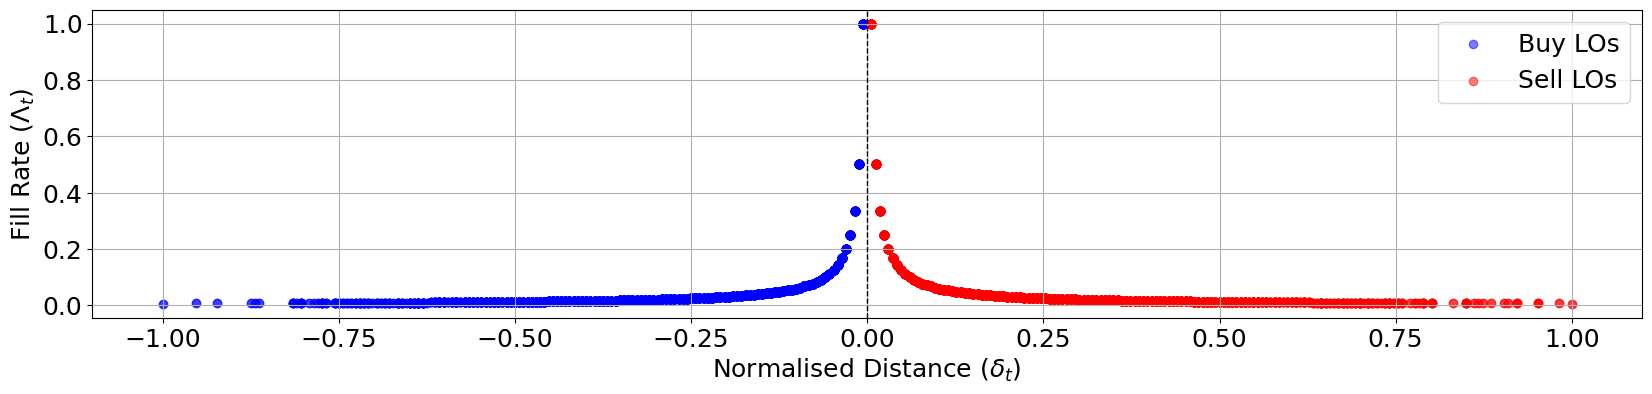

In [32]:
# Ensure merged_df exists before proceeding
if 'merged_df' in locals() or 'merged_df' in globals():
    plt.figure(figsize=(20, 4))


    # Filter out zero fill rates
    buy_fill_data = merged_df[merged_df['FillRate_Buy'] > 0].copy()
    sell_fill_data = merged_df[merged_df['FillRate_Sell'] > 0].copy()

    # FIX: Reverse Buy Depth Normalization so that smaller depths are closer to 0
    #buy_fill_data['Normalized_BuyDepth'] = -1 * ((buy_fill_data['BuyDepth'] - buy_fill_data['BuyDepth'].min())/ buy_fill_data['BuyDepth'].max())
    buy_fill_data['Normalized_BuyDepth'] = -1 * ((buy_fill_data['BuyDepth'] - buy_fill_data['BuyDepth'].min())/ buy_fill_data['BuyDepth'].max())

    # Sell Depth remains the same (0 to 1)
    sell_fill_data['Normalized_SellDepth'] = ((sell_fill_data['SellDepth'] - sell_fill_data['SellDepth'].min()) / sell_fill_data['SellDepth'].max() )

    # Scatter plot of Normalized Fill Rate vs Depth
    plt.scatter(buy_fill_data['Normalized_BuyDepth'], buy_fill_data['FillRate_Buy'], color='blue', alpha=0.5, label='Buy LOs')
    plt.scatter(sell_fill_data['Normalized_SellDepth'], sell_fill_data['FillRate_Sell'], color='red', alpha=0.5, label='Sell LOs')

    # Labels and Title
    plt.xlabel("Normalised Distance ($\delta_t$)")
    plt.ylabel("Fill Rate ($\Lambda_t$)")
    #plt.title("Fill Rate vs Normalized Depth (Buy: 0 to -1, Sell: 0 to 1)")
    plt.axvline(x=0, color='black', linestyle='dashed', linewidth=1)  # Midpoint (spread)
    plt.legend()

    # Show plot
    plt.grid()
    plt.show()
else:
    print("Error: merged_df is not defined. Please reload your data and recompute the fill rates.")


In [33]:
# 1) Filter by your cutoff on the *already* computed Normalized_BuyDepth
cutoff = -0.5
buy_fill_data = buy_fill_data[ buy_fill_data['Normalized_BuyDepth'] <= cutoff ].copy()
sell_fill_data = sell_fill_data[ sell_fill_data['Normalized_SellDepth'] >= -cutoff ].copy()
# 2) Re‑normalize the raw BuyDepth via a fresh min–max on the filtered rows
D = buy_fill_data['BuyDepth']
S = sell_fill_data['SellDepth']
buy_fill_data['Normalized_BuyDepth'] = - (D - D.min()) / (D.max() - D.min())
sell_fill_data['Normalized_SellDepth'] = (S - S.min()) / (S.max() - S.min())



In [34]:
Fb = buy_fill_data['FillRate_Buy']
buy_fill_data['NormFill_Buy'] = (Fb - Fb.min()) / (Fb.max() - Fb.min())

Fs = sell_fill_data['FillRate_Sell']
sell_fill_data['NormFill_Sell'] = (Fs - Fs.min()) / (Fs.max() - Fs.min())


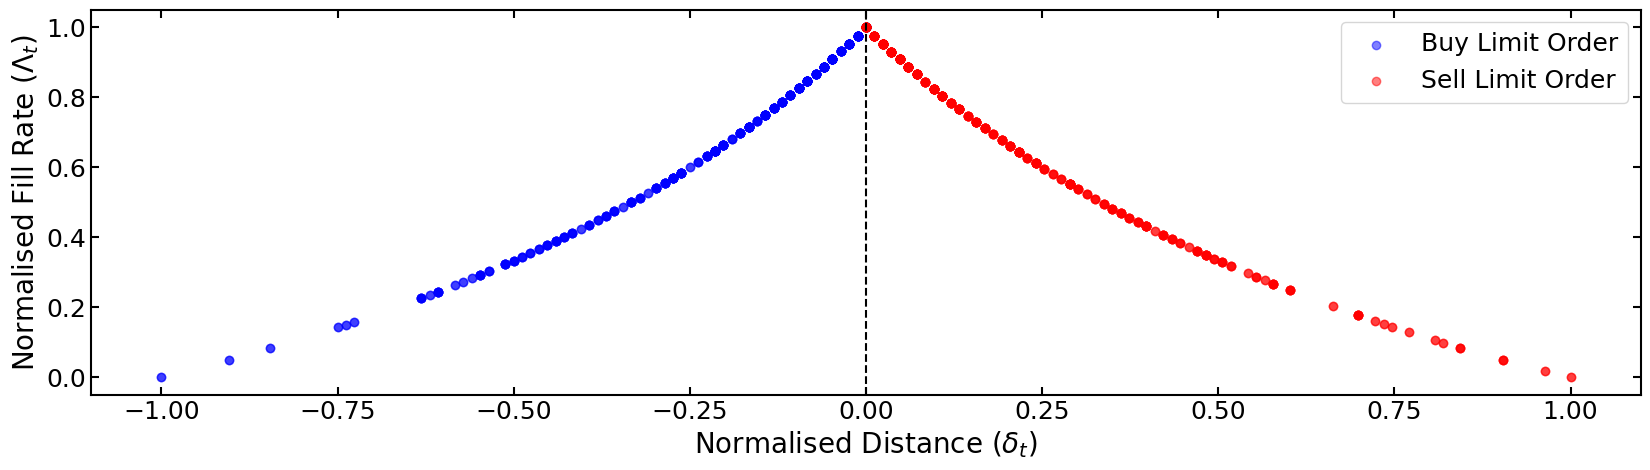

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

ax.scatter(buy_fill_data['Normalized_BuyDepth'], buy_fill_data['NormFill_Buy'],
            color='blue', alpha=0.5, label='Buy Limit Order')
ax.scatter(sell_fill_data['Normalized_SellDepth'], sell_fill_data['NormFill_Sell'],
            color='red', alpha=0.5, label='Sell Limit Order')
ax.axvline(0, color='black', linestyle='--')
ax.set_xlabel("Normalised Distance ($\\delta_t$)", fontsize=20)
ax.set_ylabel("Normalised Fill Rate ($\\Lambda_t$)", fontsize=20)
ax.tick_params(axis='both', which='major', direction='in',
                    length=6, width=1.5, labelsize=12, top=True, bottom=True, left=True, right=True)
ax.tick_params(axis='both', which='minor', direction='in', length=60, width=100,
                    top=True, bottom=True, left=True, right=True)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax = plt.gca()

ax.tick_params(axis='both', which='major', direction='in',
                    length=6, width=1.5, labelsize=18, top=True, bottom=True, left=True, right=True)
ax.tick_params(axis='both', which='minor', direction='in', length=3, width=1,
                    top=True, bottom=True, left=True, right=True)
plt.ylim(-0.05,1.05)
plt.legend();  plt.show()



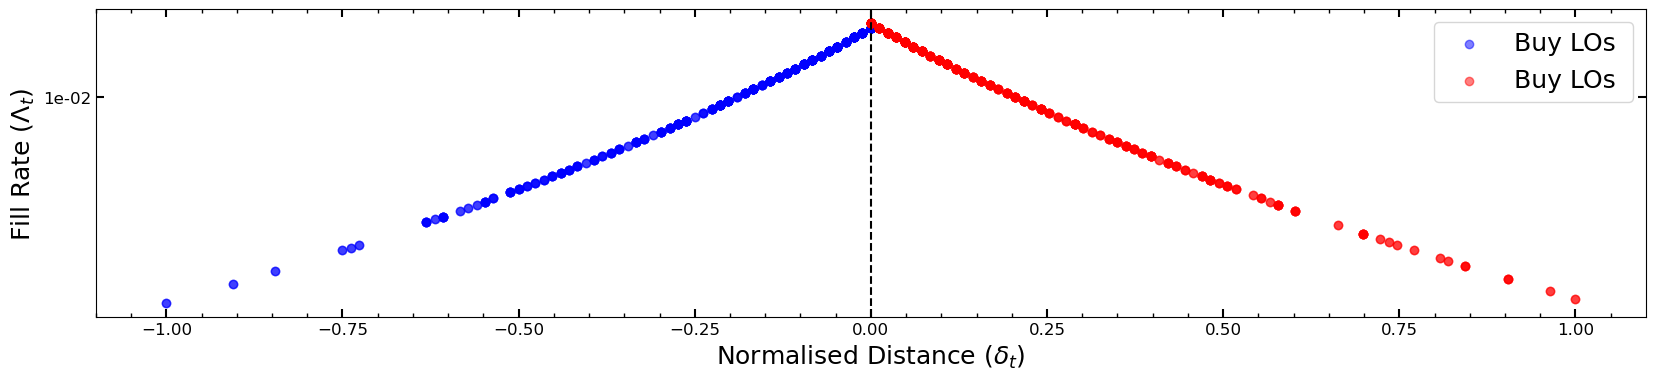

In [36]:
# Now plot as before…
plt.figure(figsize=(20,4))
plt.scatter(buy_fill_data['Normalized_BuyDepth'], buy_fill_data['FillRate_Buy'],
            color='blue', alpha=0.5, label='Buy LOs ')
plt.scatter(sell_fill_data['Normalized_SellDepth'], sell_fill_data['FillRate_Sell'],
            color='red', alpha=0.5, label='Buy LOs ')
plt.axvline(0, color='black', linestyle='dashed')
plt.xlabel("Normalised Distance ($\\delta_t$)")
plt.ylabel("Fill Rate ($\\Lambda_t$)")
plt.yscale('log', base = math.e)
import matplotlib.ticker as mticker
ax = plt.gca()

ax.tick_params(axis='both', which='major', direction='in',
                    length=6, width=1.5, labelsize=12, top=True, bottom=True, left=True, right=True)
ax.tick_params(axis='both', which='minor', direction='in', length=3, width=1,
                    top=True, bottom=True, left=True, right=True)
# Force around 6 ticks on the log axis
ax.yaxis.set_major_locator(mticker.LogLocator(base=10, numticks=6))

# Format them in scientific notation with 2 significant figures
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.e'))
plt.minorticks_on()

plt.legend();  plt.show()


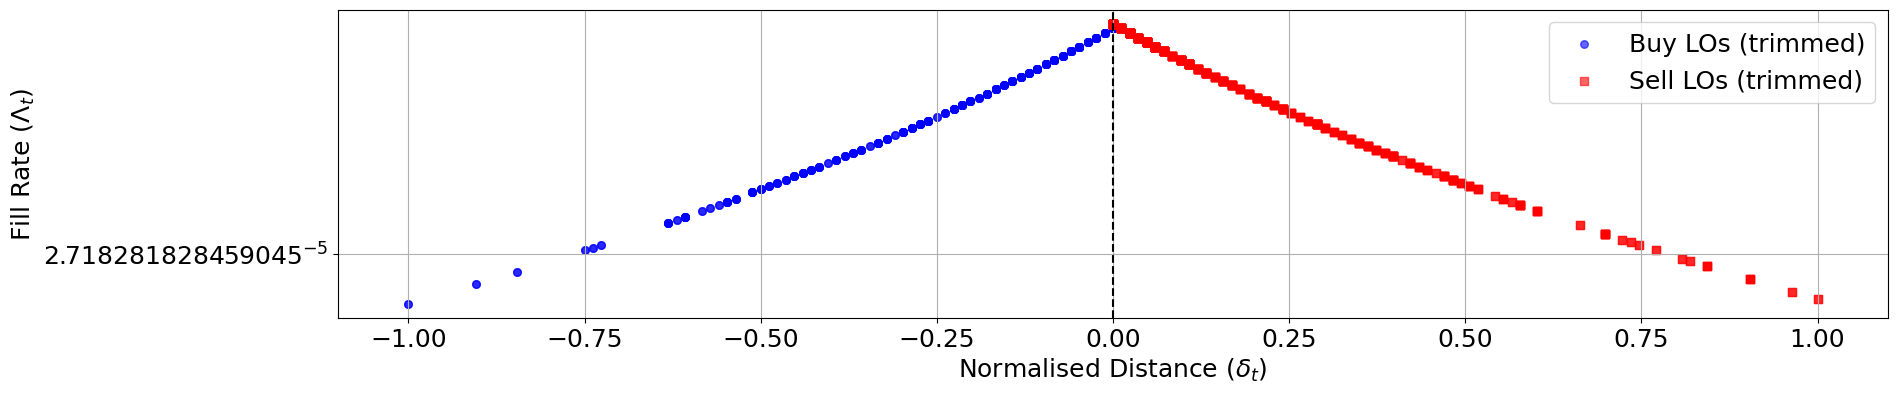

In [37]:
plt.figure(figsize=(20,4))

# buy series as blue circles
plt.scatter(
    buy_fill_data['Normalized_BuyDepth'],
    buy_fill_data['FillRate_Buy'],
    color='blue', marker='o', s=30, alpha=0.6,
    label='Buy LOs (trimmed)'
)

# sell series as red squares
plt.scatter(
    sell_fill_data['Normalized_SellDepth'],
    sell_fill_data['FillRate_Sell'],
    color='red', marker='s', s=30, alpha=0.6,
    label='Sell LOs (trimmed)'
)

plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Normalised Distance ($\\delta_t$)")
plt.ylabel("Fill Rate ($\\Lambda_t$)")
plt.yscale('log', base=math.e)
plt.legend()
plt.grid(True)
plt.show()


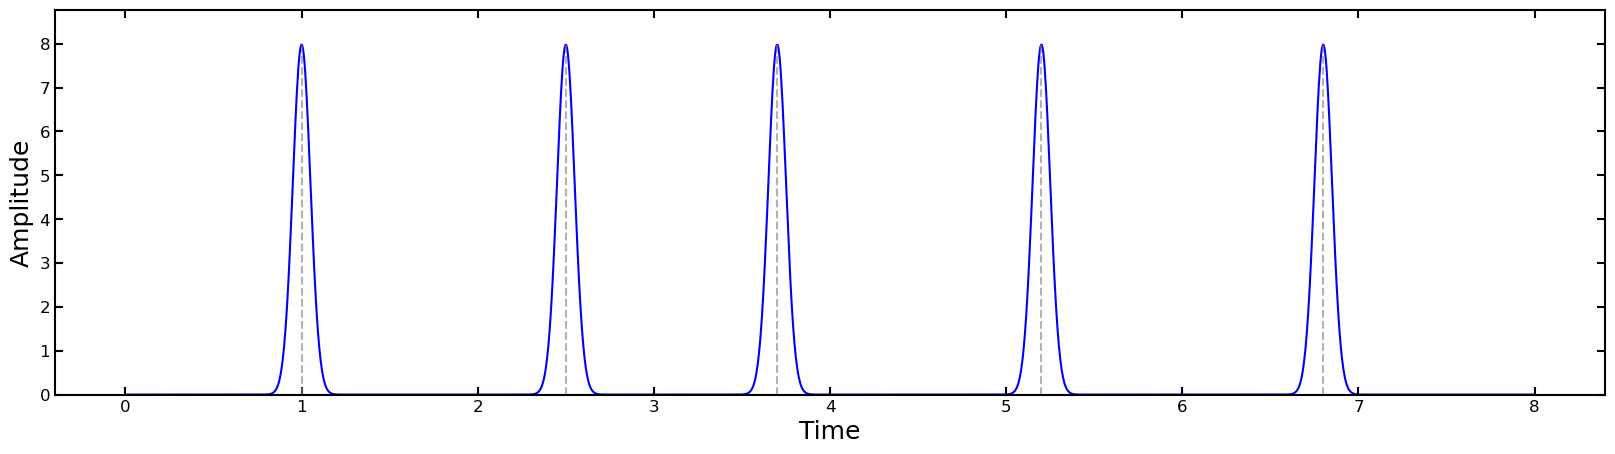

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Example arrival times (replace with your actual tau_k values)
event_times = np.array([1, 2.5, 3.7, 5.2, 6.8])

# Continuous time grid
t = np.linspace(0, 8, 2000)

# Approximate delta with narrow Gaussians (sigma small)
sigma = 0.05
delta_approx = np.zeros_like(t)
for tau in event_times:
    delta_approx += (1/(sigma * np.sqrt(2 * np.pi))) * \
                    np.exp(-0.5 * ((t - tau) / sigma)**2)

# Plot the approximation

plt.figure(figsize=(20, 5))
plt.plot(t, delta_approx, lw=1.5, color='blue', alpha=1)
plt.vlines(event_times, ymin=0, ymax=delta_approx.max(),
           linestyles='dashed', colors='gray', alpha=0.6)
plt.xlabel("Time")
ax = plt.gca()

ax.tick_params(axis='both', which='major', direction='in',
                    length=6, width=1.5, labelsize=12, top=True, bottom=True, left=True, right=True)
ax.tick_params(axis='both', which='minor', direction='in', length=3, width=1,
                    top=True, bottom=True, left=True, right=True)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.ylabel("Amplitude")
plt.ylim(0, delta_approx.max() * 1.1)
plt.show()
